---
# Importing essential modules
--- 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

---
# Loading all datasets
---

In [2]:
fact_trips = pd.read_csv("datasets/csv_files/fact_trips.csv")
dim_city = pd.read_csv("datasets/csv_files/dim_city.csv")
dim_date = pd.read_csv("datasets/csv_files/dim_date.csv")
dim_repeat_trip = pd.read_csv("datasets/csv_files/dim_repeat_trip_distribution.csv")
fact_passenger_summary = pd.read_csv("datasets/csv_files/fact_passenger_summary.csv")
monthly_target_new_passenger = pd.read_csv("datasets/csv_files/monthly_target_new_passengers.csv")
monthly_target_trips = pd.read_csv("datasets/csv_files/monthly_target_trips.csv")
city_target_passenger_rating = pd.read_csv("datasets/csv_files/city_target_passenger_rating.csv")

---
# Data cleaning
---

In [3]:
monthly_target_new_passenger['month'] = pd.to_datetime(monthly_target_new_passenger['month'])
dim_date['date'] = pd.to_datetime(dim_date["date"])
dim_date['start_of_month'] = pd.to_datetime(dim_date["start_of_month"])
dim_repeat_trip['month'] = pd.to_datetime(dim_repeat_trip['month'])
fact_trips['date'] = pd.to_datetime(fact_trips['date'])
dim_repeat_trip['trip_count'] = dim_repeat_trip['trip_count'].apply(lambda x: int(x.split('-')[0]))

---
# Exploratory Data Analysis
---

### Top and Bottom Performing Cities

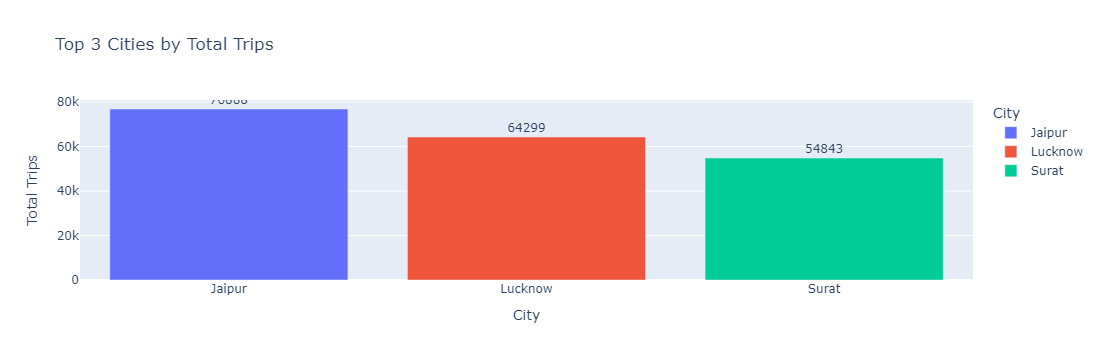

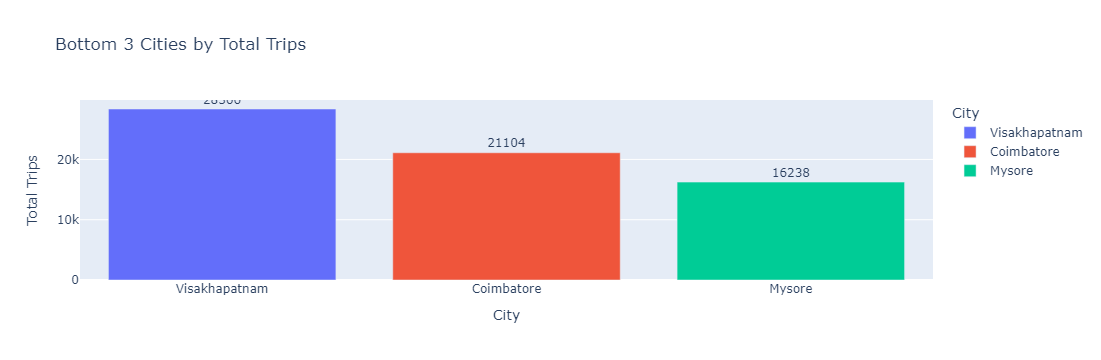

In [5]:
trips_per_city = fact_trips.groupby('city_id')['trip_id'].count().reset_index()
trips_per_city.rename(columns={'trip_id': 'total_trips'}, inplace=True)
trips_with_city_names = pd.merge(trips_per_city, dim_city, on='city_id', how='left')
sorted_trips = trips_with_city_names.sort_values(by='total_trips', ascending=False)
top_3_cities = sorted_trips.head(3)
bottom_3_cities = sorted_trips.tail(3)

# Visualization for Top 3 Cities
fig_top = px.bar(
    top_3_cities,
    x='city_name',
    y='total_trips',
    title="Top 3 Cities by Total Trips",
    labels={'city_name': 'City', 'total_trips': 'Total Trips'},
    text='total_trips',
    color='city_name'
)
fig_top.update_traces(textposition='outside')

# Visualization for Bottom 3 Cities
fig_bottom = px.bar(
    bottom_3_cities,
    x='city_name',
    y='total_trips',
    title="Bottom 3 Cities by Total Trips",
    labels={'city_name': 'City', 'total_trips': 'Total Trips'},
    text='total_trips',
    color='city_name'
)
fig_bottom.update_traces(textposition='outside')

# Show the figures
fig_top.show()
fig_bottom.show()

### Average Fare Trip by City

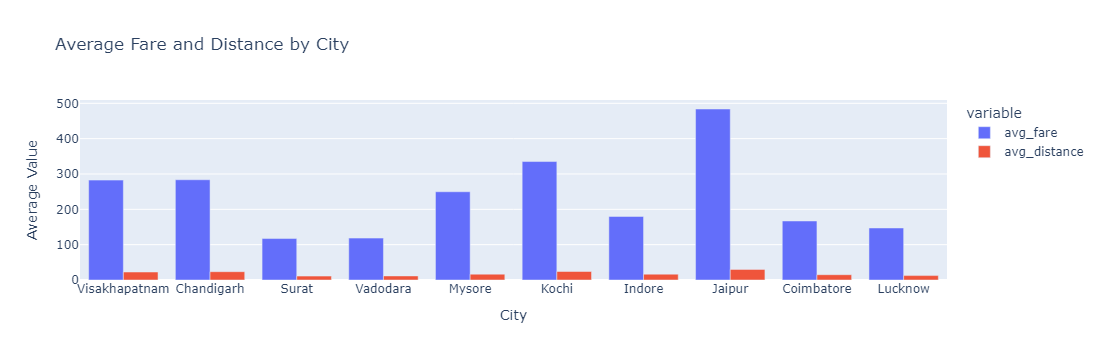

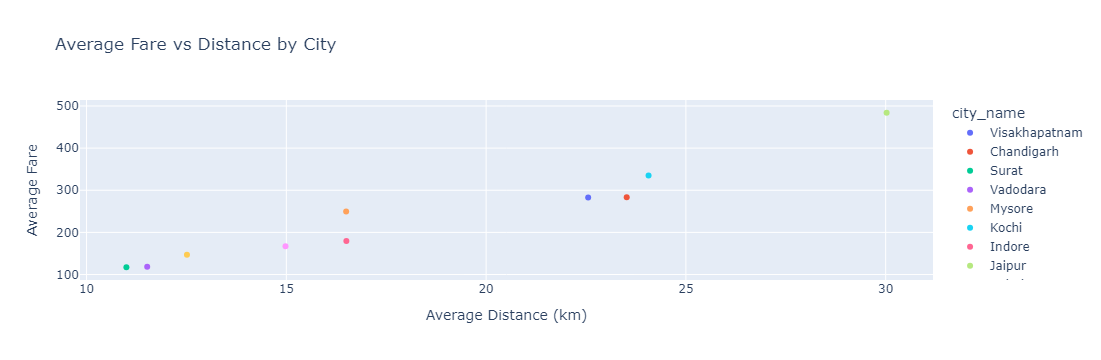

In [6]:
avg_fare_distance = fact_trips.groupby('city_id').agg(
    avg_fare=('fare_amount', 'mean'),
    avg_distance=('distance_travelled(km)', 'mean')
).reset_index()

avg_fare_distance = pd.merge(avg_fare_distance, dim_city, on='city_id', how='left')

# Bar chart for Average Fare and Distance
fig = px.bar(avg_fare_distance, 
             x='city_name', 
             y=['avg_fare', 'avg_distance'], 
             title='Average Fare and Distance by City',
             labels={'value': 'Average Value', 'city_name': 'City'},
             barmode='group')
fig.show()
fig_scatter = px.scatter(
    avg_fare_distance,
    x="avg_distance",
    y="avg_fare",
    color="city_name",
    title="Average Fare vs Distance by City",
    labels={"avg_distance": "Average Distance (km)", "avg_fare": "Average Fare"},
    hover_name="city_name",
    size_max=10
)

fig_scatter.show()

### Average Ratings by City and Passenger Type

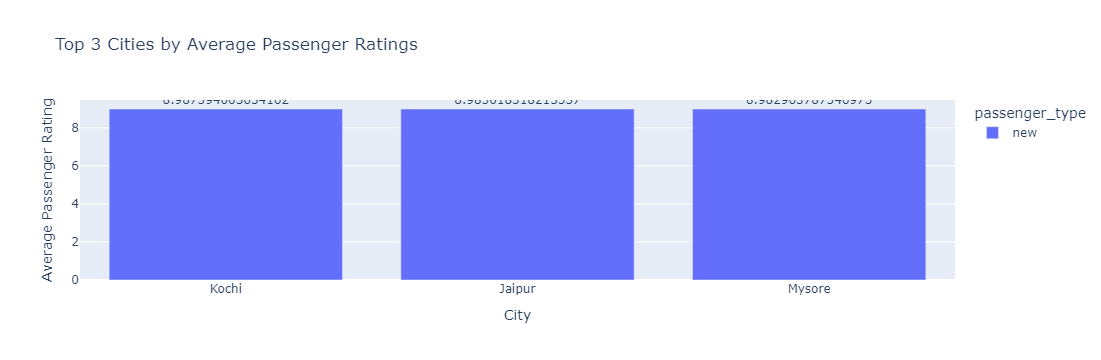

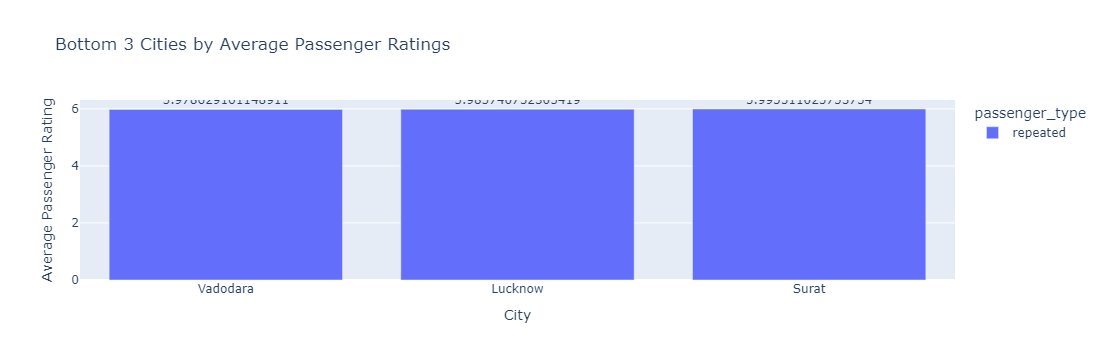

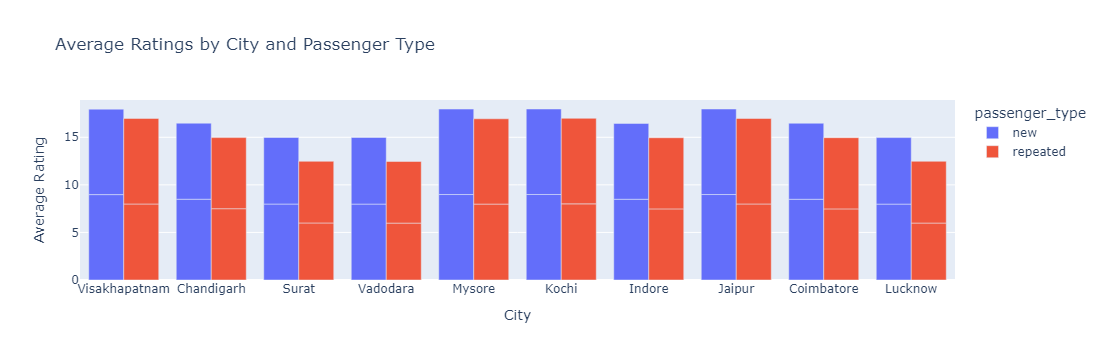

In [7]:
avg_ratings = fact_trips.groupby(['city_id', 'passenger_type']).agg(
    avg_passenger_rating=('passenger_rating', 'mean'),
    avg_driver_rating=('driver_rating', 'mean')
).reset_index()

# Merge with city names
avg_ratings = pd.merge(avg_ratings, dim_city, on='city_id', how='left')

# Identify highest and lowest ratings
highest_passenger_rating = avg_ratings.nlargest(3, 'avg_passenger_rating')
lowest_passenger_rating = avg_ratings.nsmallest(3, 'avg_passenger_rating')

# Bar chart for Ratings by City and Passenger Type
fig = px.bar(avg_ratings, 
             x='city_name', 
             y=['avg_passenger_rating', 'avg_driver_rating'], 
             color='passenger_type', 
             title='Average Ratings by City and Passenger Type',
             labels={'value': 'Average Rating', 'city_name': 'City'},
             barmode='group')

fig_high_ratings = px.bar(
    highest_passenger_rating,
    x="city_name",
    y="avg_passenger_rating",
    color="passenger_type",
    title="Top 3 Cities by Average Passenger Ratings",
    labels={"city_name": "City", "avg_passenger_rating": "Average Passenger Rating"},
    text="avg_passenger_rating"
)
fig_high_ratings.update_traces(textposition="outside")

# Plot for Lowest Passenger Ratings
fig_low_ratings = px.bar(
    lowest_passenger_rating,
    x="city_name",
    y="avg_passenger_rating",
    color="passenger_type",
    title="Bottom 3 Cities by Average Passenger Ratings",
    labels={"city_name": "City", "avg_passenger_rating": "Average Passenger Rating"},
    text="avg_passenger_rating"
)
fig_low_ratings.update_traces(textposition="outside")

# Display the figures
fig_high_ratings.show()
fig_low_ratings.show()
fig.show()

### Peak and Low Demand Months by City


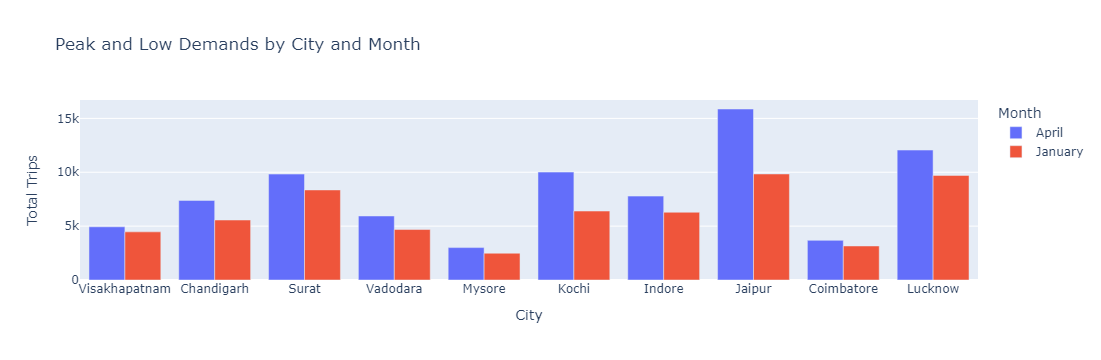

In [8]:
fact_trips_with_month = pd.merge(fact_trips,dim_date,
                                  on = 'date',
                                  how = 'left')
fact_trips_with_month = fact_trips_with_month.rename(columns={"start_of_month": "month"})
grouped_data = fact_trips_with_month.groupby(['city_id', 'month_name']).agg(total_trips=('trip_id', 'count')).reset_index()

# Identify the month with the highest and lowest trips for each city
peak_demand = grouped_data.loc[grouped_data.groupby('city_id')['total_trips'].idxmax()]
low_demand = grouped_data.loc[grouped_data.groupby('city_id')['total_trips'].idxmin()]

# Merge the peak and low demand data
peak_and_low_demand = pd.merge(peak_demand, low_demand, on='city_id', suffixes=('_peak', '_low'))

# Display the result
peak_and_low_demand = peak_and_low_demand[['city_id', 'month_name_peak', 'total_trips_peak', 'month_name_low', 'total_trips_low']]
peak_and_low_demand = peak_and_low_demand.merge(dim_city,on='city_id')

# Reshape the data so that each row corresponds to either peak or low demand
side_by_side_data = peak_and_low_demand.melt(
    id_vars=['city_name'],  # Keep city_name as an identifier
    value_vars=['total_trips_peak', 'total_trips_low'],  # Reshape the total trip counts
    var_name='demand_type',  # This will indicate peak or low demand
    value_name='total_trips'  # This column will hold the trip counts
)

# Now, create the corresponding month names for each demand type
side_by_side_data['month'] = side_by_side_data['demand_type'].apply(
    lambda x: peak_and_low_demand['month_name_peak'].values[0] if x == 'total_trips_peak' 
    else peak_and_low_demand['month_name_low'].values[0]
)

# Create the side-by-side bar chart
fig_side_by_side_demand = px.bar(
    side_by_side_data,
    x="city_name",
    y="total_trips",
    color="month",  # Color by month
    title="Peak and Low Demands by City and Month",
    labels={"city_name": "City", "total_trips": "Total Trips", "month": "Month"},
    barmode="group",  # Display side-by-side bars
)

fig_side_by_side_demand.show()

### Weekend by Weekday Trip Demand by City

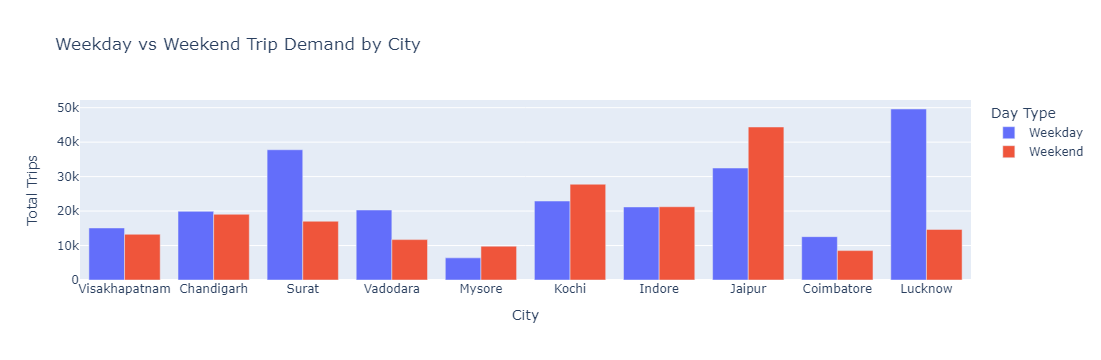

In [9]:
fact_trips_with_day_type = pd.merge(fact_trips, dim_date[['date', 'day_type']], on='date', how='left')

# Group by city and day type to calculate total trips
weekday_weekend_demand = fact_trips_with_day_type.groupby(['city_id', 'day_type']).agg(
    total_trips=('trip_id', 'count')
).reset_index()

# Merge with city names
weekday_weekend_demand = pd.merge(weekday_weekend_demand, dim_city, on='city_id', how='left')

# Visualization: Grouped Bar Chart for Weekday vs Weekend Demand

fig_weekday_weekend = px.bar(
    weekday_weekend_demand,
    x="city_name",
    y="total_trips",
    color="day_type",
    title="Weekday vs Weekend Trip Demand by City",
    labels={"total_trips": "Total Trips", "city_name": "City", "day_type": "Day Type"},
    barmode="group"
)

fig_weekday_weekend.show()

### Repeat Passenger Frequency and City Contribution Analysis

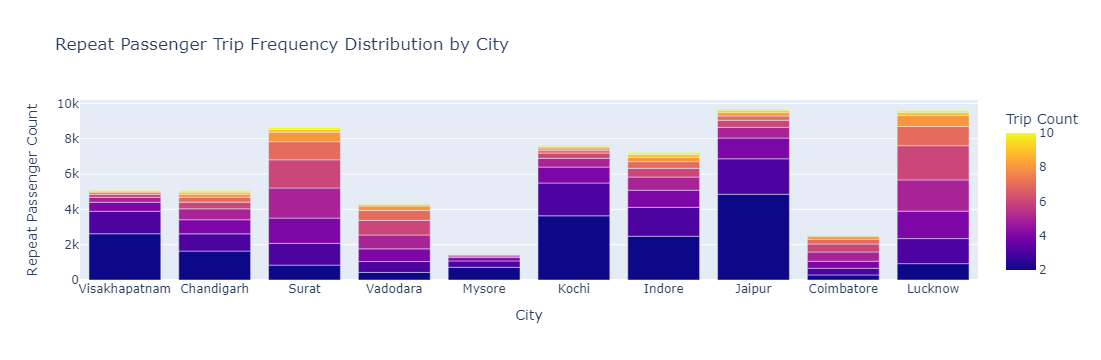

In [10]:
total_repeat_passengers = dim_repeat_trip.groupby('city_id').agg(
    total_repeat_passengers=('repeat_passenger_count', 'sum')
).reset_index()

# Merge with city names
total_repeat_passengers = pd.merge(total_repeat_passengers, dim_city, on='city_id', how='left')

# Analyze trip frequency distribution by city
repeat_trip_distribution = dim_repeat_trip.groupby(['city_id', 'trip_count']).agg(
    repeat_passenger_count=('repeat_passenger_count', 'sum')
).reset_index()

# Merge with city names for interpretability
repeat_trip_distribution = pd.merge(repeat_trip_distribution, dim_city, on='city_id', how='left')

# Visualization: Bar Chart for Repeat Passenger Trip Frequency
fig_repeat_trip_distribution = px.bar(
    repeat_trip_distribution,
    x="city_name",
    y="repeat_passenger_count",
    color="trip_count",
    title="Repeat Passenger Trip Frequency Distribution by City",
    labels={
        "repeat_passenger_count": "Repeat Passenger Count",
        "city_name": "City",
        "trip_count": "Trip Count"
    },
    barmode="group"
)

fig_repeat_trip_distribution.show()

### Monthly Target Achivement Analysis for Key Metrics

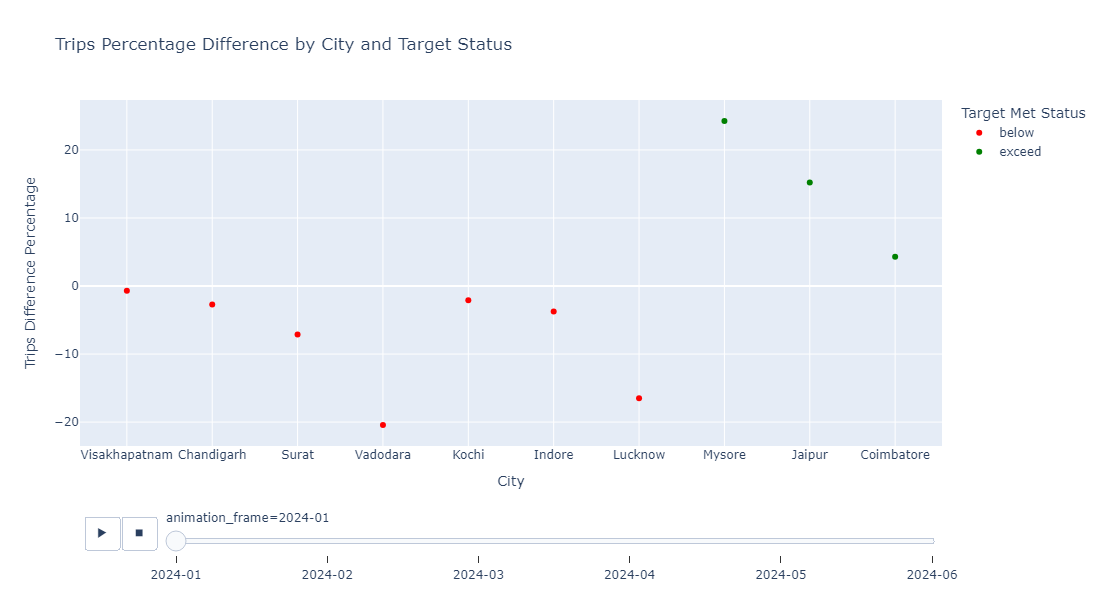

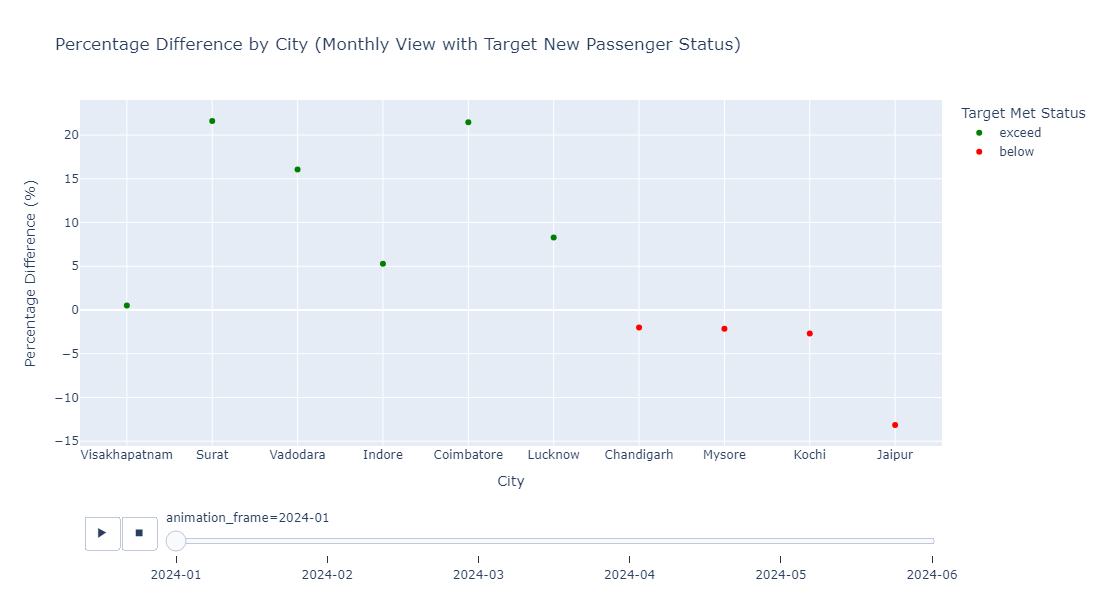

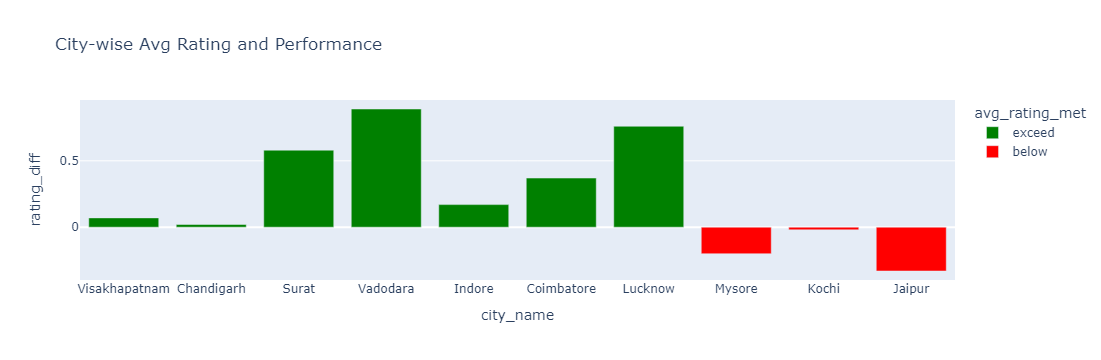

In [11]:
new_passenger_by_city_month = pd.DataFrame(fact_trips_with_month[fact_trips_with_month['passenger_type']=='new'].groupby(['month','city_id']).agg(
    total_passenger=('trip_id', 'count')
))
actual_and_target_new_passengers = pd.merge(new_passenger_by_city_month, monthly_target_new_passenger,
        on= ('month', 'city_id'),
        how= 'left')
actual_and_target_new_passengers['new_passenger_diff'] = actual_and_target_new_passengers['total_passenger'] - actual_and_target_new_passengers['target_new_passengers']
actual_and_target_new_passengers['new_passenger_diff_percent'] = (actual_and_target_new_passengers['new_passenger_diff']/actual_and_target_new_passengers['target_new_passengers'])*100
actual_and_target_new_passengers['new_passenger_diff_percent'] = actual_and_target_new_passengers['new_passenger_diff_percent'].round(2)

actual_and_target_new_passengers['target_new_passenger_met'] = pd.cut(
    actual_and_target_new_passengers['new_passenger_diff_percent'],
    bins=[-float('inf'), 0, float('inf')],
    labels=['below', 'exceed']
)

monthly_target_trips['month'] = pd.to_datetime(monthly_target_trips['month'])
total_trips_by_city_month = pd.DataFrame(fact_trips_with_month.groupby(['month','city_id']).agg(
    total_trips=('trip_id', 'count')
))
actual_and_target_trips = pd.merge(total_trips_by_city_month, monthly_target_trips,
        on= ('month', 'city_id'),
        how= 'left')
actual_and_target_trips['trips_diff'] = actual_and_target_trips['total_trips'] - actual_and_target_trips['total_target_trips']
actual_and_target_trips['trips_diff_percent'] = (actual_and_target_trips['trips_diff']/actual_and_target_trips['total_target_trips'])*100
actual_and_target_trips['trips_diff_percent'] = actual_and_target_trips['trips_diff_percent'].round(2)
actual_and_target_trips['trips_target_met'] = pd.cut(
    actual_and_target_trips['trips_diff_percent'],
    bins=[-float('inf'), 0, float('inf')],
    labels=['below', 'exceed']
)

passenger_rating_by_city = pd.DataFrame(fact_trips_with_month.groupby('city_id').agg(
    avg_rating=('passenger_rating', 'mean')
)).round(2)

actual_and_target_ratings = pd.merge(passenger_rating_by_city, city_target_passenger_rating,
        on= ('city_id'),
        how= 'left')

actual_and_target_ratings['rating_diff'] = actual_and_target_ratings['target_avg_passenger_rating'] - actual_and_target_ratings['avg_rating']

actual_and_target_ratings['avg_rating_met'] = pd.cut(
    actual_and_target_ratings['rating_diff'],
    bins=[-float('inf'), 0, float('inf')],
    labels=['below', 'exceed']
)

actual_and_target_ratings = actual_and_target_ratings.merge(dim_city, on = 'city_id', how = 'left')
actual_and_target_new_passengers = actual_and_target_new_passengers.merge(dim_city, on = 'city_id', how = 'left')
actual_and_target_trips = actual_and_target_trips.merge(dim_city, on = 'city_id', how = 'left')

fig_rating_measure = px.bar(
    actual_and_target_ratings,
    x="city_name",
    y="rating_diff",
    color="avg_rating_met",
    title="City-wise Avg Rating and Performance",
    labels={"avg_rating": "Average Rating", "city_id": "City ID"},
    color_discrete_map={"exceed": "green", "below": "red"}
)

fig_passenger_target_measure = px.scatter(
    actual_and_target_new_passengers,
    x="city_name",
    y="new_passenger_diff_percent",
    color="target_new_passenger_met",
    animation_frame=actual_and_target_new_passengers["month"].dt.strftime('%Y-%m'),  
    title="Percentage Difference by City (Monthly View with Target New Passenger Status)",
    labels={"new_passenger_diff_percent": "Percentage Difference (%)", "city_name": "City"},
    color_discrete_map={"exceed": "green", "below": "red"}
)

fig_passenger_target_measure.update_layout(
    height=600,
    xaxis_title="City",
    yaxis_title="Percentage Difference (%)",
    legend_title="Target Met Status"
)

fig_trip_target_measure = px.scatter(
    actual_and_target_trips,
    x="city_name",
    y="trips_diff_percent",
    color="trips_target_met",
    animation_frame=actual_and_target_trips["month"].dt.strftime('%Y-%m'),
    title="Trips Percentage Difference by City and Target Status",
    labels={"trips_diff_percent": "Trips Difference Percentage", "city_id": "City ID", "trips_target_met": "Target Met Status"},
    color_discrete_map={"exceed": "green", "below": "red"}
)

fig_trip_target_measure.update_layout(
    height=600,
    xaxis_title="City",
    yaxis_title="Trips Difference Percentage",
    legend_title="Target Met Status"
)

fig_trip_target_measure.show()
fig_passenger_target_measure.show()
fig_rating_measure.show()

### Highest and Lowest Repeat Passenger Rate by City and Month

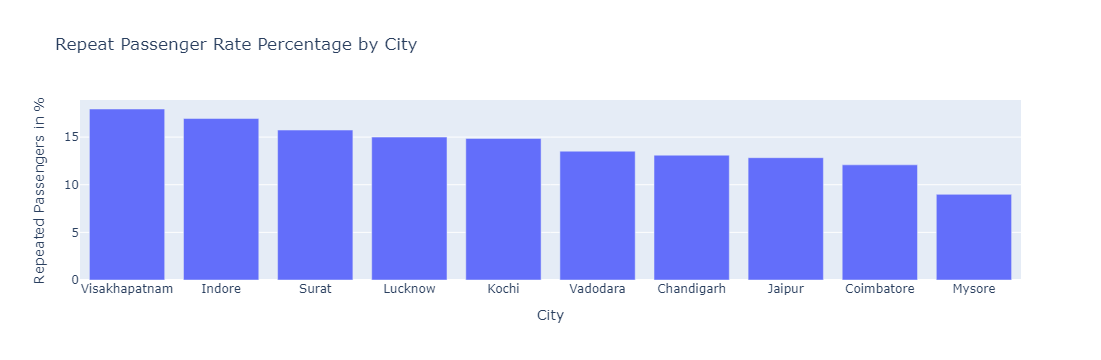

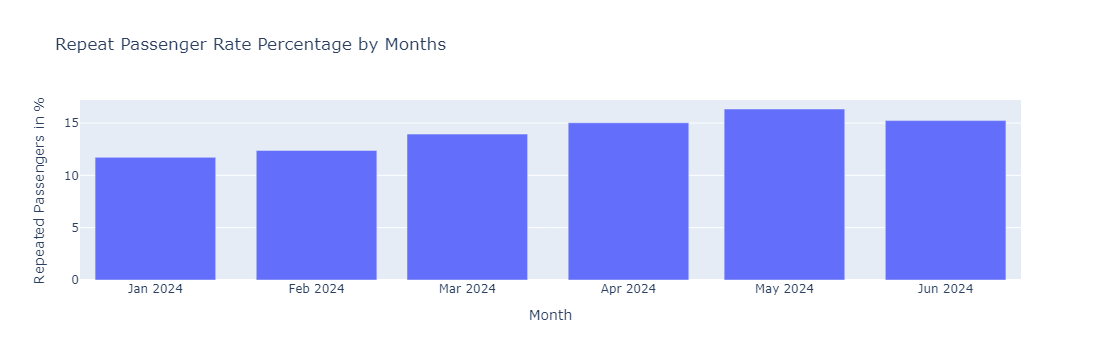

In [22]:
dim_repeat_trip['trip_count']= dim_repeat_trip['trip_count'].astype("int")

dim_repeat_trip['trip_repeat_product'] = dim_repeat_trip['trip_count'] * dim_repeat_trip['repeat_passenger_count']

total_trip_repeat_product = dim_repeat_trip.groupby(['city_id', 'month']).agg(
    total_repeat_passengers_sum=('repeat_passenger_count', 'sum')
).reset_index()

total_trips_by_city_month= fact_trips_with_month.groupby(['city_id','month']).agg(
    total_trips=('trip_id','count')
).reset_index()

total_trips_repeated_trips_sum = pd.merge(total_trip_repeat_product,total_trips_by_city_month,
                                         on=['city_id','month'],
                                         how= 'left')

total_trips_repeated_trips_sum.rename(columns = {'total_repeat_passengers_sum':'repeated_paasengers'}, inplace=True)
total_trips_repeated_trips_sum['repeated_passengers_percent'] = (total_trips_repeated_trips_sum['repeated_paasengers']/total_trips_repeated_trips_sum['total_trips'])*100
total_trips_repeated_trips_sum.sort_values(by='repeated_passengers_percent', ascending=False)
total_trips_repeated_trips_sum = pd.merge(
    total_trips_repeated_trips_sum, dim_city,
    on = 'city_id'
)

city_avg_repeated_passenger_percent= total_trips_repeated_trips_sum.groupby(['city_name']).agg(
    city_avg_repeated_passengers_percent = ('repeated_passengers_percent', 'mean')
).reset_index()

month_avg_repeated_passenger_percent= total_trips_repeated_trips_sum.groupby(['month']).agg(
    month_avg_repeated_passengers_percent = ('repeated_passengers_percent', 'mean')
).reset_index()

city_avg_repeated_passenger_percent = city_avg_repeated_passenger_percent.sort_values(by = 'city_avg_repeated_passengers_percent', ascending=False)
city_avg_repeated_passenger_percent = city_avg_repeated_passenger_percent.round(2)
month_avg_repeated_passenger_percent = month_avg_repeated_passenger_percent.sort_values(by = 'month_avg_repeated_passengers_percent', ascending=False)
month_avg_repeated_passenger_percent = month_avg_repeated_passenger_percent.round(2)

fig_repeat_passengers_distribution = px.bar(
    city_avg_repeated_passenger_percent,
    x="city_name",
    y="city_avg_repeated_passengers_percent",
    title="Repeat Passenger Rate Percentage by City",
    labels={
        "city_name": "City",
        "city_avg_repeated_passengers_percent": "Repeated Passengers in %"
    }
)


fig_repeat_passengers_distribution2 = px.bar(
    month_avg_repeated_passenger_percent,
    x="month",
    y="month_avg_repeated_passengers_percent",
    title="Repeat Passenger Rate Percentage by Months",
    labels={
        "month": "Month",
        "month_avg_repeated_passengers_percent": "Repeated Passengers in %"
    }
)

fig_repeat_passengers_distribution.show()
fig_repeat_passengers_distribution2.show()